In [1]:
'''
Available methods are the followings:
[1] cluster_pie
[2] cluster_hist
[3] cluster_scatter
[4] cluster_matrix
[5] cluster_radar
[6] create_cmap
[7] matplotlib_cmap
[8] adjust_label

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 22-07-2021

'''
import pandas as pd, numpy as np, math
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import gaussian_filter1d
from scipy import (stats, linalg)

from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.ticker import(FixedLocator, 
                              FixedFormatter, 
                              StrMethodFormatter,
                              FuncFormatter)
from mpl_toolkits.axes_grid1 import Grid
from itertools import product

plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Hiragino Sans GB'})
plt.rc('axes', unicode_minus=False)

__all__  = ["matplotlib_cmap", "create_cmap",
            "cluster_pie", 
            "cluster_hist", 
            "cluster_scatter",
            "cluster_matrix",
            "cluster_radar", 
            "adjust_label"]

In [2]:
def matplotlib_cmap(name='viridis', n=10):

    '''
    Parameters
    ----------
    name : matplotlib Colormap str, default='viridis'
        Name of a colormap known to Matplotlib. 
    
    n : int, defualt=10
        Number of shades for defined color map.
    
    Returns
    -------
    colors : list of color-hex
        List of color-hex codes from defined Matplotlib Colormap. 
        Such list contains "n" shades.
        
    '''
    c_hex = '#%02x%02x%02x'
    c = cm.get_cmap(name)(np.linspace(0,1,n))
    c = (c*255).astype(int)[:,:3]
    colors = [c_hex % (c[i,0],c[i,1],c[i,2]) for i in range(n)]
    return colors

In [3]:
def create_cmap(colors=None):
    
    '''
    Creating matplotlib.colors.Colormap (Colormaps).
    
    Parameters
    ----------
    colors : list of hex-colors or RGBs, default=None
        The beginning color code [(255,10,8),(255,255,255)]
  
    Returns
    -------
    matplotlib ListedColormap
    
    '''
    # Convert to RGB
    to_RGB = lambda c: tuple(int(c[i:i+2],16) for i in (0,2,4))
    if colors is None: colors = [(255,10,8), (255,255,255)]
    colors = np.array([to_RGB(c.lstrip('#')) if isinstance(c, str) 
                       else c for c in colors])/256
    rgb = []
    for c1,c2 in zip(colors[:-1],colors[1:]):
        rgb.append(np.array([np.linspace(c1[i],c2[i],256) 
                             for i in range(3)]).T)
    rgb = np.vstack(rgb)
    rgb = rgb[np.arange(len(rgb)-1,-1,-1),:]
    return ListedColormap(rgb, name="Customized_cmap")

In [70]:
def cluster_pie(y, ax=None, labels=None, colors=None, 
                pie_kwds=None, tight_layout=True):
    
    '''
    Plot a cluster pie chart.
    
    Parameters
    ----------
    y : 1D-array or pd.Series
        Array of cluster labels (0 to n_clusters-1)
    
    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, ax is created 
        with default figsize.
    
    labels : list, default: None
        A sequence of strings providing the labels for each 
        class. If None, 'Cluster {n+1}' is assigned, where n 
        is the class in y.
        
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to
        number of classes. If None, it uses default colors 
        from Matplotlib
    
    pie_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.pie".

    tight_layout : bool, default=True
        If True, it adjusts the padding between and around 
        subplots i.e. plt.tight_layout().
    
    References
    ----------
    .. [1] https://matplotlib.org/stable/api/_as_gen/
           matplotlib.pyplot.pie.html
    
    Returns
    -------
    ax : Matplotlib axis object
    
    '''
    # Create matplotlib.axes if ax is None.
    if ax is None: ax = plt.subplots(figsize=(5, 4))[1]
    
    unq, unq_count = np.unique(y, return_counts=True)
    labels = ([f"Cluster {n}" for n in unq+1] 
              if labels is None else labels)
    
    kwds = dict(explode = (unq_count==max(unq_count)).astype(int)*0.1,
                colors  = ([ax._get_lines.get_next_color() for _ in unq] 
                           if colors is None else colors), 
                labels  = ['{}\n({:,d})'.format(*v) for 
                           v in zip(labels, unq_count)], 
                autopct = "{:,.0f}%".format, 
                shadow  = True, 
                startangle = 90, labeldistance=1.3,
                wedgeprops = dict(edgecolor="#2f3640", lw=2), 
                textprops  = dict(fontsize=13, ha="center", 
                                  fontweight=500, color="#2f3640"))
    ax.pie(unq_count, **(kwds if pie_kwds is 
                         None else {**kwds,**pie_kwds}))
    ax.axis('equal')
    if tight_layout: plt.tight_layout()
    return ax

In [5]:
def cluster_hist(x, y=None, ax=None, labels=None, colors=None, 
                 fill_kwds=None, plot_kwds=None, tight_layout=True, 
                 bins="fd", sigma=0.5, whis=1.5, plot_order=None):
    
    '''
    Plot a cluster Kernal Density Estimation (KDE) chart.
    
    Parameters
    ----------
    x : 1D-array or pd.Series
        Sample input. All elements must be finite, i.e. no NaNs or 
        infs. 

    y : 1D-array or pd.Series of int, default=None
        Array of cluster labels (0 to n_clusters-1). If None, an 
        array of single class is used instead.
    
    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, ax is created with 
        default figsize.

    labels : list, default: None
        A sequence of strings providing the labels for each class. If 
        None, 'Cluster {n+1}' is assigned, where n is the class in y.
    
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to number 
        of classes. If None, it uses default colors from Matplotlib.
    
    fill_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.fill_between".
    
    plot_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.plot".
        
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around 
        subplots i.e. plt.tight_layout().
        
    bins : int or str, default="fd"
        Number of bins (np.histogram_bin_edges) [1].
    
    sigma : float, default=None
        Standard deviation for Gaussian kernel. Sigma must be greater 
        than 0. The higher the sigma the smoother the probability 
        density curve (PDF). If None, it uses bin_width derived from
        `bins`.
        
    whis : float, default=1.5  
        It determines the reach of the whiskers to the beyond the 
        first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
        whis*IQR, respectively. This applies to both coordinates and 
        lower and upper bounds accordingly.
    
    plot_order : list of int, default=None
        List of class order to be plotted.
    
    References
    ----------
    .. [1] https://numpy.org/doc/stable/reference/generated/numpy.
           histogram_bin_edges.html#numpy.histogram_bin_edges
    
    Returns
    -------
    ax : Matplotlib axis object
    
    '''
    # Create matplotlib.axes if ax is None.
    if ax is None: ax = plt.subplots(figsize=(5, 4))[1]
    
    # Default value: y
    y = (np.zeros(len(X)) if y is None else y).astype(int)
    
    # Default : colors
    unique = np.unique(y)
    colors = ([ax._get_lines.get_next_color() for _ in unique] 
              if colors is None else colors)
    
    # Default : plot_order
    plot_order = np.array(unique if plot_order 
                          is None else plot_order)
    
    # Default : labels
    labels = ([f"Cluster ({n})" for n in plot_order+1] 
              if labels is None else labels)
    
    # Determine bins.
    bins   = np.histogram(x, bins)[1]
    xticks = bins[1:] + np.diff(bins)
    if sigma is None: sigma = np.diff(bins)[0]
    
    for n,c in enumerate(plot_order):
        
        # 1-D Gaussian filter (smoothen density curve)
        density = np.histogram(x[y==c], bins, density=True)[0]
        pdf = gaussian_filter1d(density, sigma)

        # Density plot (ax.fill_between)
        kwds = dict(color=colors[n], label=labels[n], alpha=0.3)
        if fill_kwds is not None: kwds.update(fill_kwds)
        ax.fill_between(xticks, pdf, **kwds)
        
        # Density line (ax.plot)
        kwds = dict(color=colors[n], lw=2.5)
        ax.plot(xticks, pdf, **({**kwds, **plot_kwds} 
                                if plot_kwds is not None else kwds))
    if len(plot_order)>1: ax.legend(loc=0, fontsize=11)
    ax.set_ylim(*np.array(ax.get_ylim())*[[1,1/0.85]])
    ax.set_xlim(__IQR__(x, whis, *ax.get_xlim()))
    if tight_layout: plt.tight_layout()
    return ax

In [6]:
def cluster_scatter(x1, x2, y=None, ax=None, labels=None, 
                    colors=None, scatter_kwds=None, 
                    tight_layout=True, whis=1.5, 
                    frac=1, random_state=0,
                    use_kde=False, cmap=None, plot_order=None):
    
    '''
    Plot a cluster scatter chart.
    
    Parameters
    ----------
    x1, x2 : 1D-array or pd.Series
        The horizontal, and vertical coordinates of the data points, 
        respectively. All elements must be finite, i.e. no NaNs or 
        infs. 
    
    y : 1D-array or pd.Series of int, default=None
        Array of cluster labels (0 to n_clusters-1). If None, an 
        array of single class is used instead.
    
    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, ax is created with 
        default figsize.

    labels : list, default: None
        A sequence of strings providing the labels for each class. If 
        None, 'Cluster {n+1}' is assigned, where n is the class in y.

    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to number 
        of classes. If None, it uses default colors from Matplotlib.
    
    scatter_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.scatter".

    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
              
    whis : float, default=1.5
        It determines the reach of the whiskers to the beyond the 
        first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
        whis*IQR, respectively. This applies to both coordinates and 
        lower and upper bounds accordingly.
    
    frac : float, default=1
        Fraction of items to be plotted.
        
    random_state : int, default=0
        Seed for random number generator to randomize samples to be 
        plotted.
    
    use_kde : bool, default=False
        If True, a kernel-density estimate using Gaussian kernels is 
        used, otherwise scatter plots [1].
    
    cmap : str or Colormap, default=None
        A Colormap instance e.g. cm.get_cmap('Reds',20) or registered 
        colormap name. This is relevant when use_kde is True [2]. If 
        None, it defaults to "Blues".
        
    plot_order : list of int, default=None
        List of class order to be plotted.
    
    References
    ----------
    .. [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.
           stats.gaussian_kde.html
    .. [2] https://matplotlib.org/stable/tutorials/colors/colormaps.html
    
    Returns
    -------
    ax : Matplotlib axis object
    
    '''
    # Create matplotlib.axes if ax is None.
    if ax is None: ax = plt.subplots(figsize=(5, 4))[1]
    
    # Default value: y
    y = (np.zeros(len(x1)) if y is None else y).astype(int)
    
    # Default : colors
    unique = np.unique(y)
    colors = ([ax._get_lines.get_next_color() for _ in unique] 
              if colors is None else colors)
    
    # Default : plot_order
    plot_order = np.array(unique if plot_order 
                          is None else plot_order)
    
    # Default : labels
    labels = ([f"Cluster ({n})" for n in plot_order+1] 
              if labels is None else labels)
 
    # Keep x1, x1, and y given plot_order
    plot_index = np.isin(y, plot_order)
    x1 = np.array(x1)[plot_index]
    x2 = np.array(x2)[plot_index]
    y  = np.array(y)[plot_index]
    
    # Randomize x1, x2, and y (if not None)
    indices= __indices__(len(x1), frac, random_state)
    Select = lambda x, index: np.array(x).ravel()[indices]
    x1, x2 = Select(x1, indices), Select(x2, indices), 
    y = Select(y, indices)

    # Compute kernel-density estimate using Gaussian kernels
    if use_kde==True:
        
        if cmap is None: cmap = 'Blues' 
        if isinstance(cmap, str): 
            cmap = cm.get_cmap(cmap, 50)
        
        try:
            data = np.vstack((x1,x2))
            values = gaussian_kde(data).evaluate(data)
        except: values = gaussian_kde(x1).evaluate(x1)
            
        kwds = dict(c=values, cmap=cmap, marker='s', alpha=0.8, s=10)
        ax.scatter(x1, x2, **({**kwds, **scatter_kwds} if scatter_kwds 
                              is not None else kwds))
    # Scatter plot
    elif use_kde==False:
        
        kwds = dict(fc="none", marker='s', alpha=0.8, s=10)
        for n,c in enumerate(plot_order):
            kwds.update(dict(ec=colors[n], label=labels[n]))
            ax.scatter(x1[(y==c)], x2[(y==c)], 
                       **({**kwds, **scatter_kwds} if scatter_kwds 
                          is not None else kwds))
    
    # Set limits of coordinates.
    ax.set_xlim(__IQR__(x1, whis, *ax.get_xlim()))
    ax.set_ylim(__IQR__(x2, whis, *ax.get_ylim()))
    if (not use_kde) & (len(plot_order)>1): 
        ax.legend(loc=0, fontsize=11)
    if tight_layout: plt.tight_layout()
        
    return ax

In [7]:
def __IQR__(a, whis, a_min, a_max):
    
    '''Private Function: Interquatile range'''
    Q1,Q3 = np.percentile(a, [25, 75])
    if Q1==Q3: return (a_min, a_max)
    else: return (np.fmax(Q1-whis*(Q3-Q1),a_min), 
                  np.fmin(Q3+whis*(Q3-Q1),a_max))
    
def __indices__(N, frac=1, random_state=0):
    
    '''Private Function: Random indices'''
    # Select samples
    np.random.seed(random_state)
    indices = np.arange(0,N)
    if frac<1:
        kwds = dict(size=np.fmax(int(frac*N), 10), replace=False)
        select = np.random.choice(indices, **kwds)
    else: select = indices.copy()
    return np.isin(indices, select)

In [8]:
def cluster_matrix(X, y=None, colors=None, whis=1.5, plot_order=None, 
                   off_diagonal="scatter", hist_kwds=None, 
                   scatter_kwds=None, n_limit=1000, figsize=None, 
                   show_corr=True, label_kwds=None):

    '''
    Draw a matrix of scatter plots towards a pairwise comparison to 
    observe interaction of variables. NaN is ignored. Each numeric 
    variable in data will be shared across a single row and the 
    x-axes across a single column.

    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Input sample.
       
    y : 1D-array or pd.Series of int, default=None
        Array of cluster labels (0 to n_clusters-1). If None, an 
        array of single class is used instead. This overrides 
        `hist_kwds` and `scatter_kwds`.
    
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to number 
        of classes. If None, it uses default colors from Matplotlib. 
        This overrides `hist_kwds` and `scatter_kwds`.
        
    whis : float, default=1.5
        It determines the reach of the whiskers to the beyond the 
        first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
        whis*IQR, respectively. This applies to both coordinates and 
        lower and upper bounds accordingly. This overrides `hist_kwds` 
        and `scatter_kwds`.
        
    plot_order : list of int, default=None
        List of class order to be plotted. This overrides `hist_kwds` 
        and `scatter_kwds`.
         
    off_diagonal : {"scatter", "kde", "both"}, default="scatter"
        Pick between "kde", "scatter", and "both" for either Kernel 
        Density Estimation or scatter or both in the off-diagonal. 
        This overrides `scatter_kwds`.
   
    hist_kwds : keywords, default=None
        Keyword arguments to be passed to "cluster_hist".
    
    scatter_kwds : keywords, default=None
        Keyword arguments to be passed to "cluster_scatter".
        
    n_limit : int, default=1000
        Number of instances to be plotted in the off-diagonal plots. 
        n_limit should be less than len(X).
        
    figsize : (float,float), default=None
        A tuple (width, height) in inches. If None, a default figsize 
        is applied i.e. (n_rows*1.3, n_cols*1.3).
    
    show_corr : bool, default=True
        If True, it shows a Pearson correlation coefficient for every 
        pariwise plot (off-diagonal).
        
    label_kwds : keyword, default=None
        Keyword arguments to be passed to "adjust_label". If None, it
        defaults to {"max_lines":2, "factor":0.95, "suffix":"...."}.
    
    Returns
    -------
    grid : numpy.ndarray, of shape (n_rows, n_cols)
        A matrix of plots.

    '''
    # A grid of Axes (mpl_toolkits.axes_grid1).
    n_rows, n_cols = (X.shape[1],)*2
    figsize = (n_rows*1.3, n_cols*1.3) if figsize is None else figsize
    fig = plt.figure(figsize=figsize)
    grid = np.array(Grid(fig, rect=111, nrows_ncols=(n_rows,n_cols), 
                         share_x=False, share_y=False, axes_pad=0))
    
    # Fraction, Pairs of variables, and axes.
    frac, columns = np.fmin(n_limit/len(X),1), X.columns
    pairs = zip(list(product(columns, columns)), grid, 
                product(range(n_rows), range(n_cols)))
    y = (np.zeros(len(X)) if y is None else y).astype(int)

    for (var1,var2), ax, (r,c) in pairs:
        
        notna = (X[[var1,var2]].notna().sum(axis=1)==2).values
        
        if notna.sum()>0:
            
            x1 = X.loc[notna, var1].copy()
            x2 = X.loc[notna, var2].copy()
            y0 = y[notna].copy()
            
            # Diagonal plot
            if var1==var2:
                
                default   = {"plot_kwds": {"lw":1}}
                hist_kwds = (default if hist_kwds is None else 
                             {**default, **hist_kwds})
                kwds = dict(y=y, ax=ax, colors=colors, whis=whis, 
                            plot_order=plot_order, tight_layout=False)
                ax = cluster_hist(x1, **{**hist_kwds, **kwds})

            # Off-diagonal plot
            elif var1!=var2: 
                
                default = {"scatter_kwds": dict(s=5, alpha=0.5)}
                scatter_kwds = (default if scatter_kwds is None 
                                else {**default, **scatter_kwds})
                    
                use_kde = (True if off_diagonal=="kde" else False)
                if (off_diagonal=="both") & (c>r): use_kde = False
                elif (off_diagonal=="both") & (c<r): use_kde = True   
                    
                kwds = dict(y=y0, ax=ax, frac=frac, whis=whis,
                            colors=colors, plot_order=plot_order, 
                            tight_layout=False, use_kde=use_kde)    
                ax = cluster_scatter(x2, x1, **{**scatter_kwds, **kwds})

                if show_corr:
                    corr, pvalue = stats.pearsonr(x1, x2)
                    ax.text(0.95, 0.05, ('%.2f' % corr), size=11, 
                            transform=ax.transAxes, ha="right", va="bottom",
                            bbox=dict(boxstyle='round' , alpha=1, pad=0.2,
                                      facecolor='white', edgecolor='none'))
                    
            if ax.get_legend() is not None: ax.legend().set_visible(False)      
            ax.set(xticks=[], yticks=[])  
            if c==0: ax.set_ylabel(var1, fontsize=12)
            if r==n_rows-1: ax.set_xlabel(var2, fontsize=12)        
    
    # Adjust labels both x and y axis.
    plt.tight_layout(pad=0)
    if label_kwds is None: 
        label_kwds = {"max_lines":2, "factor":0.95, "suffix":"...."}
    for ax in grid[0::n_cols]: adjust_label(ax, "y", **label_kwds)
    for ax in grid[-n_cols: ]: adjust_label(ax, "x", **label_kwds)   

    return grid.reshape((n_rows, n_cols))

In [9]:
def adjust_label(ax, which="x", max_lines=2, factor=0.95, 
                 suffix="....", fig=None):

    '''
    Adjust label to stay within defined length.
    
    Parameters
    ----------
    ax : Matplotlib axis object
        Predefined Matplotlib axis.
        
    which : {"x", "y"}, default="x"
        Which axis to change label.
    
    max_lines : int, default=2
        Maximum number of lines.
        
    factor : positive float, default=0.95
        Positive number that is used to scale either width of height 
        of `ax` to determine the box boundary.
    
    suffix : str, default="...."
        String that is added to the end of last line.
    
    fig : Figure, default=None
        The Figure that `ax` is built in. If None, it defaults to 
        current figure (plt.gcf()).
        
    Returns
    -------
    ax : Matplotlib axis object
        Matplotlib axis.
        
    '''
    if fig is None: fig = plt.gcf()
    renderer = fig.canvas.get_renderer()
    Bbox_axis_ = ax.get_window_extent(renderer=renderer)
    Bbox_label = getattr(ax, f"{which}axis").get_label()
    Bbox_label = Bbox_label.get_window_extent(renderer=renderer)
    name = "width" if which=="x" else "height"
    denom = getattr(Bbox_axis_, name) * factor

    if denom > 0:
        ratio  = getattr(Bbox_label, name) / denom
        label_ = list(getattr(ax,f"get_{which}label")())
        length = int(np.floor(len(label_)/ratio))
        
        # Maximum line of texts.
        n_lines = int(np.ceil(ratio))
        max_lines = int(min(n_lines, max_lines))

        new_label = []
        for n in range(max_lines):
            t = "".join(label_[n*length:(n+1)*length])
            if (length==len(t)) & (n==max_lines-1) & (n_lines > max_lines):
                new_label += [t[:-len(suffix)] + suffix]
            else: new_label += [t]   
        getattr(ax, f"set_{which}label")("\n".join(new_label))
    return ax

In [10]:
def cluster_radar(X, y=None, ax=None, q=50, colors=None, labels=None, 
                  fill_kwds=None, plot_kwds=None, labels_format=None,
                  plot_order=None, tight_layout=True):

    '''
    Plot a cluster radar chart. X is normalized.
    
    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Input sample.
        
    y : 1D-array or pd.Series of int, default=None
        Array of cluster labels (0 to n_clusters-1). If None,
        an array of single class is used instead.

    ax : Matplotlib axis object, default=None
        Predefined PolarAxesSubplot. If None, ax is created 
        with default figsize.

    q : float, default=50
        Percentile to compute, which must be between 0 and 100 
        e.g. If `q` is 70, that means values (normalized) from 
        all classes will be determined at 70th-percentile. 
    
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to
        number of classes. If None, it uses default colors 
        from Matplotlib. 

    labels : list, default: None
        A sequence of strings providing the labels for each 
        class. If None, 'Cluster {n+1}' is assigned, where n 
        is the class in y.
        
    fill_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.fill".
    
    plot_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.plot".
    
    labels_format : string formatter, default=None
        String formatters (function) for ax.set_xticklabels 
        values. If None, it defaults to "{:,.2f}".format.

    plot_order : list of int, default=None
        List of class order to be plotted. 
        
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around 
        subplots i.e. plt.tight_layout().
        
    Returns
    -------
    ax : Matplotlib axis object

    '''
    # Check number of columns.
    if X.shape[1]<=2:
        raise ValueError(f"Number of columns must be greater " 
                         f"than 2. Got {X.shape[1]} instead.")
    
    # Create matplotlib.axes if ax is None.
    if ax is None: 
        fig = plt.figure(figsize=(6.5, 6))
        ax  = plt.subplot(polar=True)
    
    # Default value: y
    y = (np.zeros(len(X)) if y is None else y).astype(int)
    
    # Default : colors
    unique = np.unique(y)
    colors = ([ax._get_lines.get_next_color() for _ in unique] 
              if colors is None else colors)
    
    # Default : plot_order
    plot_order = np.array(unique if plot_order 
                          is None else plot_order)
    
    # Default : labels
    labels = ([f"Cluster {n}" for n in plot_order+1] 
              if labels is None else labels)
    
    # Default : xticklabels format
    labels_format = ("{:,.2f}".format if labels_format 
                     is None else labels_format)
    
    # To display all variables, particularly those that 
    # have difference in scale, we normalize `X`. This 
    # makes `X` stays within 0 and 1, which allows 
    # comparison possible across variables and classes.
    a_min, a_max = np.nanpercentile(X.values, q=[0,100], axis=0)
    norm_X = ((X.values - a_min) / 
              np.where((a_max-a_min)==0, 1, a_max-a_min))

    # Angle of plots.
    angles = [n/float(X.shape[1])*2*np.pi 
              for n in range(norm_X.shape[1])]
    angles+= angles[:1]
    angles = np.array(angles)

    # If you want the first axis to be on top.
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
     
    # Draw one axis per variable and add ticklabels. 
    ax.set_xticks(angles[:-1])
    xticklabels = [f"{f}\n(" + ", ".join((labels_format(v0), 
                                          labels_format(v1))) + ")"
                   for f,v0,v1 in zip(X.columns, a_min, a_max)]  
    ax.set_xticklabels(xticklabels, color='#3d3d3d', fontsize=12)
    
    # Set alignment of ticks.
    for n,t in enumerate(ax.get_xticklabels()):
        if (0<angles[n]<np.pi): t._horizontalalignment = 'left'
        elif (angles[n]>np.pi): t._horizontalalignment = 'right'
        else: t._horizontalalignment = 'center'

    for n,c in enumerate(plot_order):
        
        values = np.nanpercentile(norm_X[y==c], q, axis=0).tolist()
        values+= [values[0]]
        
        # ax.plot
        kwds = {'linewidth' : 2.5, 
                'color'     : colors[n], 
                "label"     : labels[n],
                "zorder"    : 2*(n + 1) - 1,
                "solid_capstyle":'round', 
                "solid_joinstyle":"round"}
        ax.plot(angles, values, **(kwds if plot_kwds is None 
                                   else {**kwds,**plot_kwds}))

        kwds = {'alpha':0.3, 'color':colors[n], "zorder":2*(n+1)}
        ax.fill(angles, values, **(kwds if fill_kwds is None 
                                   else {**kwds,**fill_kwds}))
        
    # Remove lines for radial axis (y)
    ax.set(yticks=[], yticklabels=[])
    ax.yaxis.grid(False)    
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_max)
    
    # Keyword arguments for annotations.
    default = dict(textcoords='offset points', fontsize=12, color="grey", 
                   xytext=(10, 10), va="center", ha="left", zorder=-1, 
                   bbox=dict(facecolor="w", pad=0.2, 
                             edgecolor='none', boxstyle="round"),
                   arrowprops = dict(arrowstyle = "-", color="#cccccc"))
    
    # Draw minor grid along with annotations.
    for v in np.linspace(y_min, y_max, 5)[:-1]:
        kwds = dict(color="#cccccc", lw=0.8, zorder=-1)
        ax.plot(angles, np.full(len(angles),v), **kwds)
        ax.annotate("{:,.2f}".format(v) , (0, v), **default ) 
        
    # Draw perimeter.
    ax.plot(angles, np.full(len(angles), y_max), 
            color="grey", lw=2, zorder=-1)       
    ax.xaxis.grid(True, color="#cccccc", lw=0.8, zorder=-1)

    # Remove spines
    ax.spines["polar"].set_color("none")
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    ax = adjust_legend(ax, len(labels))
    
    if tight_layout: plt.tight_layout()
        
    return ax

def bounding_box(obj):
    
    '''Private function: Get bounding box'''
    fig = plt.gcf()
    renderer = fig.canvas.get_renderer()
    return (obj.get_window_extent(renderer=renderer)
            .transformed(plt.gca().transAxes))
    
def adjust_legend(ax, n_labels):

    '''Private function: Relocate legend to the bottom'''
    # Get (x0,y0), and (x1,y1) of all text boxes.
    ax_bbox = bounding_box(ax)
    x_, y_ = [], []
    for t in ax.get_xticklabels():
        t_bbox = bounding_box(t)
        x_.append([t_bbox.x0, t_bbox.x1])
        y_.append([t_bbox.y0, t_bbox.y1])

    # Determine maximum width.
    x_pos, y_pos = np.r_[x_], np.r_[y_]
    x_min, x_max = np.percentile(x_pos.ravel(), q=[0,100])
    max_width = (x_max - x_min)*0.9

    # Find height of textbox in axis coordinates.
    y0, y1 = y_pos[np.argmin(y_pos[:,0]), :]
    ax_height = ax_bbox.height
    t0_height = (y1 - y0)/ax_height
    new_y0    = (y0-ax_bbox.y0)/ax_height

    # Determine `ncol` that is best fit the legend.
    best_cols = 1
    kwds = dict(edgecolor="none" , borderaxespad=0.25, 
                markerscale =1.00, columnspacing=0.30, 
                labelspacing=0.70, handletextpad=0.50, 
                prop={"size":12} , loc='center')

    for c in range(1, n_labels+1):
        kwds.update({"ncol":c})
        legend = bounding_box(ax.legend(**kwds)) 
        gap = np.ceil(n_labels/c) * c - n_labels
        if (gap < 2) & (legend.width < max_width):
            best_cols = c

    kwds.update({"ncol": best_cols})
    # bbox_to_anchor=(1.05, 1)
    legend = ax.legend(**kwds) 
    legend_bbox = bounding_box(legend)
    dy = (legend_bbox.y1 - legend_bbox.y0)/ax_height
    dy = new_y0 - (0.5 * dy + t0_height)
    legend.set_bbox_to_anchor([0.5, dy], transform=ax.transAxes)
    
    return ax

In [11]:
'''
Available methods are the followings:
[1] FactorRotation
[2] PrincipalComponents
[3] Cal_Bartlett
[4] Cal_KMOScore 
[5] Cal_PartialCorr 
[6] Cal_SMC

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 22-07-2021

'''
import pandas as pd, numpy as np, math
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import gaussian_filter1d
from scipy import (stats, linalg)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import matplotlib.tri as tri
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.ticker import (FixedLocator, 
                               FixedFormatter, 
                               StrMethodFormatter,
                               FuncFormatter)
from itertools import product
import collections

plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Hiragino Sans GB'})
plt.rc('axes', unicode_minus=False)

__all__  = ["FactorRotation", 
            "PrincipalComponents", 
            "Cal_Bartlett", 
            "Cal_KMOScore", "KMO_table",
            "Cal_PartialCorr", 
            "Cal_SMC"]

In [12]:
class FactorRotation():
    
    '''
    FactorRotation provides statistical information towards 
    interpretation of factor loadings, specific variances, and 
    communalities from "factor-analyzer" [1].
   
    Atrributes
    ----------
    loadings : pd.DataFrame
        The correlation coefficient between variables and factors.
    
    communalities : pd.DataFrame
        The elements are squared loadings, which represent the 
        variance of each item that can be explainded by the 
        corresponding factor. 

    variances : pd.DataFrame
        Total Variance Explained of initial eigenvalues (PCA), and 
        after extraction. 

    common_variances : pd.DataFrame
        Correlation or variance between variables that can be 
        explained by factors. Communalities are on the diagonal. 
        Value closer to 1 suggests that factors explain more of the 
        variance of variables [1].

    unique_variances : pd.DataFrame
        Unique variance is comprised of specific variances (diagonal) 
        and residual variances (off-diagonal). These variances can not 
        be explained by factors [1]. 

    rmsr : float
        According to the model assumptions stating that specific 
        factors are uncorrelated with one another, cov(ϵi,ϵj) = 0 for 
        i ≠ j, the off-diagonal elements from unique_variances should 
        be small towards zeros, which can be measured by Root-Mean-
        Square Residual (RMSR) [1].

    References
    ----------
    .. [1] https://factor-analyzer.readthedocs.io/en/latest/factor_
           analyzer.html#factor-analyzer-analyze-module
    .. [2] https://online.stat.psu.edu/stat505/book/export/html/691

    '''
    def __init__(self):
        pass
        
    def fit(self, estimator, features=None):
        
        '''
        Fit model.
        
        Parameters
        ----------
        estimator : estimator object.
            An estimator of "factor-analyzer" or other that implements 
            the similar interface [1].
        
        features : list of str, default=None
            A list of features. If None, features default to ["X1","X2", 
            ...,"Xn"] where n is the number of features according to 
            "loadings".
            
        Atrributes
        ----------
        loadings : pd.DataFrame
            The correlation coefficient between variables and factors.

        communalities : pd.DataFrame
            The elements are squared loadings, which represent the 
            variance of each item that can be explainded by the 
            corresponding factor. 

        variances : pd.DataFrame
            Total Variance Explained of initial eigenvalues (PCA), and 
            after extraction. 

        common_variances : pd.DataFrame
            Correlation or variance between variables that can be 
            explained by factors. Communalities are on the diagonal. 
            Value closer to 1 suggests that factors explain more of the 
            variance of variables [1].

        unique_variances : pd.DataFrame
            Unique variance is comprised of specific variances (diagonal) 
            and residual variances (off-diagonal). These variances can not 
            be explained by factors [1]. 

        rmsr : float
            According to the model assumptions stating that specific 
            factors are uncorrelated with one another, cov(ϵi,ϵj) = 0 for 
            i ≠ j, the off-diagonal elements from unique_variances should 
            be small towards zeros, which can be measured by Root-Mean-
            Square Residual (RMSR) [1].
        
        References
        ----------
        .. [1] https://factor-analyzer.readthedocs.io/en/latest/factor_
               analyzer.html#factor-analyzer-analyze-module
        .. [2] https://online.stat.psu.edu/stat505/book/export/html/691
        
        '''
        # Attributes from estimator
        n_factors = estimator.n_factors
        loadings  = estimator.loadings_
        corr_     = estimator.corr_
        n_features= len(corr_)
 
        factors = [f"F{n}" for n in range(1, n_factors+1)]
        if features is not None: features = list(features)
        else: features = [f"X{n+1}" for n in range(n_features)]
    
        # Initial and extracted variances
        columns = ["Total", "% Variance", "Cumulative %"]
        columns = list(product(["Initial","Extraction"], columns))
        columns = pd.MultiIndex.from_tuples(columns)
        index   = pd.Index([f"F{n+1}" for n in range(n_features)])
        
        initial = estimator.get_eigenvalues()[0]  
        initvar = initial / n_features
        initial = np.vstack((initial, initvar, np.cumsum(initvar))).T
        extract = np.vstack((np.vstack(estimator.get_factor_variance()).T,
                             np.full((n_features-n_factors,3), [np.nan]*3)))
        self.variances = pd.DataFrame(np.hstack((initial, extract)), 
                                      columns=columns, index=index)
    
        # Communality (common variance), and 
        # Uniqueness (specific variance + error).
        columns =(list(product(["Extraction"], factors + 
                               ["Communality","Uniqueness"])))
        columns = pd.MultiIndex.from_tuples(columns)
    
        commu = (loadings**2).sum(axis=1, keepdims=True)
        data  = np.hstack((loadings**2, commu, 1-commu))
        data  = np.vstack((data, data.sum(0, keepdims=True)))
        self.communalities = pd.DataFrame(data, columns=columns,
                                          index=features + ["Total"])
                                          
        # Correlation and Cov(e(i),e(j)) given n_factors
        kwds = dict(columns=features, index=features)
        corr = loadings.dot(loadings.T)
        self.common_variances = pd.DataFrame(corr, **kwds)
        self.unique_variances = corr_ - self.common_variances
            
        # Calculate Root Mean Square Residual (RMSR)
        # res(i,j) = Cov(e(i),e(j)) = 0
        off_diag = ~np.diag(np.full(n_features, True))
        errors = sum((corr_-corr)[off_diag]**2)
        denom  = n_features*(n_features-1)
        self.rmsr = np.sqrt(errors/denom)
        self.loadings = pd.DataFrame(loadings, 
                                     columns=factors, 
                                     index=features)
                                     
        return self
    
    def plotting(self, value=None, ax=None, cmap=None, pcolor_kwds=None, 
                 anno_kwds=None, anno_format=None, tight_layout=True):
        
        '''
        Plot chart of eigenvectors or correlations.

        Parameters
        ----------
        value : {"loading", "common", "unique"}
            Data input to be used in the functon. If None, it defaults to 
            "loading".
            
        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis. If None, ax is created with default 
            figsize.

        cmap : str or Colormap, default=None
            A Colormap instance e.g. cm.get_cmap('Reds',20) or registered 
            colormap name. If None, it defaults to "Blues". This overrides 
            `pcolor_kwds`.

        pcolor_kwds : keywords, default=None
            Keyword arguments to be passed to "ax.pcolor".
            
        anno_kwds : keywords, default=None
            Keyword arguments to be passed to "ax.annotate".
            
        anno_format : string formatter, default=None
            String formatters (function) for ax.annotate values. If None, 
            it defaults to "{:,.2f}".format.
            
        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots 
            i.e. plt.tight_layout().

        Returns
        -------
        ax : Matplotlib axis object
        
        '''
        params = {"loading": ("loadings", 
                              r"Correlations, $\hat{L}=corr(X,PC)$"), 
                  "common" : ("common_variances", 
                              r"Correlations, $\hat{L}=corr(X,PC)$"), 
                  "unique" : ("unique_variances", 
                              r"Residual variances, $cov(e_{i},e_{j})$")}
        
        value = "loading" if value is None else value
        data, title = params[value]
        data = getattr(self, data)
        data = data.reindex(index=data.index[::-1])
        n_rows, n_cols = data.shape
 
        # Create matplotlib.axes if ax is None.
        if ax is None: 
            ax = plt.subplots(figsize=(n_cols, n_rows-.5))[1]
        
        # Matplotlib Colormap
        if cmap is None: cmap = 'Blues' 
        if isinstance(cmap, str): cmap = cm.get_cmap(cmap,50)
        
        abs_val = abs(data).values.ravel()
        kwds = dict(edgecolors='#4b4b4b', lw=1, alpha=0.8, 
                    vmin=min(abs_val), vmax=max(abs_val))
        kwds = (kwds if pcolor_kwds is None 
                else {**kwds, **pcolor_kwds})
        ax.pcolor(abs(data), **{**kwds,**{"cmap":cmap}})

        # Annotation.
        anno_xy = [[m+0.5,n+0.5] for n in range(n_rows) 
                   for m in range(n_cols)]
        anno_format = ("{:,.2f}".format if anno_format 
                       is None else anno_format)
        kwds = dict(xytext =(0,0), textcoords='offset points', 
                    va='center', ha='center', fontsize=12, 
                    fontweight='demibold', color="Black")
        kwds = (kwds if anno_kwds is None else {**kwds,**anno_kwds})
        
        for xy, v in zip(anno_xy, data.values.ravel()): 
            ax.annotate(anno_format(v), xy, **kwds)

        ax.tick_params(tick1On=False)
        ax.set_xticks(np.arange(0.5, n_cols))
        ax.set_xticklabels(data.columns)
        
        ax.set_yticks(np.arange(0.5, n_rows))
        ax.set_yticklabels(data.index)
        ax.set_title(title, fontsize=14)
        if tight_layout: plt.tight_layout()
            
        return ax

In [13]:
class PrincipalComponents:
    
    '''
    PrincipalComponents performs dimension reduction algorithm 
    so-called Principal Component Analysis (PCA) on the correlation 
    of X.
    
    Parameters
    ----------
    mineigval : float, default=1
        Minimum value of eigenvalues when choosing number of 
        prinicpal components. The algorithm chooses factor, whose 
        eigenvalue is more than mineigval. Only available when
        method is either "eigval" or None.

    minprop : float, default=0.8
        Minimum proportion of variation explained when choosing 
        number of prinicpal components. The algorithm select a
        group of factors (ranked from highest to lowest by 
        eigenvalues), whose sum of variation explained is greater 
        than or equal to minprop.
        
    method : {"eigval", "varprop"}, default=None
        If "eigval", mineigval is selected as a threshold, whereas 
        "varprop" uses minprop. If None, a maximum number of 
        factors is selected between two methods.
        
    Attributes
    ----------
    eigvals : ndarray of shape (n_components,)
        The variance that get explained by factors.

    eigvecs : pd.DataFrame of shape (n_features, n_components)
        Eigenvectors (or factors) are vectors whose direction 
        remain unchanged when a linear transformation is applied. 
        They represent the directions of maximum variance. The 
        factors are sorted by eigvals.

    variances : pd.DataFrame
        Variance that can be explained by a given factor. Starting 
        from the first factor, each subsequent factor is obtained 
        from partialling out the previous factor. Therefore the 
        first factor explains the most variance, and the last factor 
        explains the least [1].

    communalities : pd.DataFrame
        The communality is the sum of the squared component loadings 
        up to the number of components that gets extracted [1].

    References
    ----------
    .. [1] https://stats.idre.ucla.edu/spss/seminars/efa-spss/
   
    '''
    def __init__(self, minprop=0.8, mineigval=1.0, method=None):
    
        self.minprop = minprop
        self.mineigval = mineigval
        self.method = method
    
    def fit(self, X):
        
        '''
        Fit PCF model.
        
        Parameters
        ----------
        X : pd.DataFrame, of shape (n_samples, n_features)
            Sample data.
        
        Atrributes
        ----------
        eigvals : ndarray of shape (n_components,)
            The variance that get explained by factors
        
        eigvecs : pd.DataFrame of shape (n_features, n_components)
            Eigenvectors (or factors) are vectors whose direction 
            remain unchanged when a linear transformation is applied. 
            They represent the directions of maximum variance. The 
            factors are sorted by eigvals.
            
        variances : pd.DataFrame
            Variance that can be explained by a given factor. Starting 
            from the first factor, each subsequent factor is obtained 
            from partialling out the previous factor. Therefore the 
            first factor explains the most variance, and the last factor 
            explains the least [1].
            
        communalities : pd.DataFrame
            The communality is the sum of the squared component loadings 
            up to the number of components that gets extracted [1].
            
        References
        ----------
        .. [1] https://stats.idre.ucla.edu/spss/seminars/efa-spss/
 
        '''
        if isinstance(X, pd.DataFrame):
            if X.shape[1]<=2:
                raise ValueError(f'n_features must be greater than 2.' 
                                 f'Got {X.shape[1]} instead.')
        else: raise TypeError(f'Data must be pd.DataFrame.' 
                              f' Got {type(X)} instead.')
        
        # Create PC columns
        width = int(np.ceil(np.log(X.shape[1])/np.log(10)))
        self.components = ["PC{}".format(str(n).zfill(width)) 
                           for n in range(1,X.shape[1]+1)]
        
        # Standardize X
        self.mean = np.mean(X.values, axis=0)
        self.stdv = np.std(X.values, axis=0)
        std_X = ((X.values-self.mean)/self.stdv).copy()
        
        # Correlation matrix
        corr = pd.DataFrame(std_X).corr().values
        
        # Eigenvalues, Eigenvectors, and loadings
        eigvals, eigvecs = np.linalg.eigh(corr)
        indices = np.argsort(eigvals)[::-1]
        self.eigvals = eigvals[indices].real
        self.eigvecs = pd.DataFrame(eigvecs[:,indices].real, 
                                    columns=self.components, 
                                    index=X.columns)
        loadings = self.eigvecs*np.sqrt(self.eigvals)
        
        # Variance explained
        varprops = self.eigvals/self.eigvals.sum()
        cumprops = np.cumsum(varprops)
        
        # Factors
        data = np.vstack((self.components, self.eigvals, 
                          varprops, cumprops))
        columns = ["Factor", "Eigenvalues", "% Variance", "Cumulative %"]
        self.variances = (pd.DataFrame(data.T, columns=columns)
                          .set_index("Factor").astype("float64"))
    
        # Recommended number of factors
        n_minprop = np.argmax((cumprops>=self.minprop))+1
        n_maxeigval = (eigvals>=self.mineigval).sum()

        if self.method=="eigval": n_factors = n_maxeigval
        elif self.method=="varprop": n_factors = n_minprop
        else: n_factors = max([n_minprop, n_maxeigval, 1])
        self.n_factors = n_factors
        
        # Communalities
        columns = list(product(["Extraction"], 
                               self.components[:n_factors] +
                               ["Communality"]))
        columns = pd.MultiIndex.from_tuples(columns)
        variances = (loadings.values**2)[:,:n_factors]
        communalities = variances.sum(axis=1, keepdims=True)
        data = np.hstack((variances, communalities))
        data = np.vstack((data, data.sum(0, keepdims=True)))
        self.communalities = pd.DataFrame(data, columns=columns, 
                                          index=list(X)+["Total"])
        
        # Data for plots
        eigvecs_ = self.eigvecs.values[:,:n_factors]
        keys = ["eigvals", "eigvecs", "varprops", "princoms", "features"]
        results = collections.namedtuple("Results", keys)
        self.results_ = results(**{"eigvals" : self.eigvals[:n_factors], 
                                   "eigvecs" : eigvecs_, 
                                   "varprops": varprops, 
                                   "princoms": std_X.dot(eigvecs_),
                                   "features": list(X)})
            
        return self

    def transform(self, X, n_factors=None):

        '''
        Apply the dimensionality reduction on X.
        
        Parameters
        ----------
        X : pd.DataFrame, of shape (n_samples, n_features)
            Sample data.
        
        n_factors : int, default=None
            Number of factors. If None, it is selected according 
            to "method".
            
        Returns
        -------
        PC : pd.DataFrame, of shape (n_samples, n_comps)
            Transformed X.
        
        '''
        std_X = (X-self.mean)/self.stdv
        n_factors = self.n_factors if n_factors is None else max(n_factors,1)
        PC = np.dot(std_X, self.eigvecs.values[:,:n_factors])
        return pd.DataFrame(PC, columns=self.components[:n_factors])
    
    def fit_transform(self, X, n_factors=None):
        
        '''
        Fit X and apply the dimensionality reduction on X.
        
        Parameters
        ----------
        X : pd.DataFrame, of shape (n_samples, n_features)
            Sample data.
        
        n_factors : int, default=None
            Number of factors. If None, it is selected according 
            to "method".
            
        Returns
        -------
        PC : pd.DataFrame, of shape (n_samples, n_comps)
            Transformed X.
        '''
        self.fit(X)
        return self.transform(X, n_factors)
    
    def plot(self, ax=None, y=None, scatter_colors=None, arrow_colors=None, 
             pc_pair=(0,1), target=None, exclude=None, proportion=0.5, 
             max_display=10, show_corr=False, whis=1.5, scatter_kwds=None, 
             tight_layout=True):
    
        '''
        Plot results.

        Parameters
        ----------
        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis. If None, it uses default size, 
            figsize=(9, 5).

        y : array-like of shape (n_samples,), default=None
            The target values (class labels) in integer. If None, a single
            class is used.

        scatter_colors : array-like of shape (n_classes,), default=None
            List of color-hex must be arranged in correspond to class label
            (integer). If None, it uses default colors from Matplotlib.

        arrow_colors : array-like of shape (n_features,), default=None
            List of color-hex must be arranged in correspond to n_features. 
            If None, it uses default colors from Matplotlib.

        pc_pair : (int, int), default=(0,1)
            Pair of principal component indices for x and y axis, 
            respectively.

        target : array-like of shape (n_samples,), default=None
            Binary target i.e. target=1, and non-target=0. If provided, it 
            draws red circle around targets.

        exclude : list of str, default=None
            List of features to be excluded from the plot.

        proportion : float, default=0.5
            Minimum proportion of variation explained by two principal 
            components when choosing variables to be displayed. It selects 
            variables whose explained variance is greater than or equal to
            `proportion`.

        max_display : int, greater than 1, default=10
            Maximum number of variables to be displayed. If None, it uses 
            all variables that satisfy `propotion`.

        show_corr : bool, default=False
            If True, it shows correlation coefficients between variable,
            and principal components on x and y axes, respectively in the 
            legend, otherwise explained variance.

        whis : float, default=1.5
            It determines the reach of the whiskers to the beyond the 
            first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
            whis*IQR, respectively. This applies to both coordinates and 
            lower and upper bounds accordingly.

        scatter_kwds : keywords, default=None
            Keyword arguments to be passed to "ax.scatter".

        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots i.e. 
            plt.tight_layout().

        Returns
        -------
        ax : Matplotlib axis object
    
        '''
        args = (self.results_, ax, y, scatter_colors, arrow_colors, pc_pair, 
                target, exclude, proportion, max_display, show_corr, whis, 
                scatter_kwds, tight_layout)
        return plot_pcf_base(*args)

In [14]:
def plot_pcf_base(Results, ax=None, y=None, scatter_colors=None, 
                  arrow_colors=None, pc_pair=(0,1), target=None, 
                  exclude=None, proportion=0.5, max_display=10, 
                  show_corr=False, whis=1.5, scatter_kwds=None, 
                  tight_layout=True):
    
    '''
    Plot results from `PrincipalComponents`.

    Parameters
    ----------
    Results : namedtuple
        self.results_ (attribute) from `PrincipalComponents` class.

    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, it uses default size, 
        figsize=(9, 5).

    y : array-like of shape (n_samples,), default=None
        The target values (class labels) in integer. If None, a single
        class is used.

    scatter_colors : array-like of shape (n_classes,), default=None
        List of color-hex must be arranged in correspond to class label
        (integer). If None, it uses default colors from Matplotlib.
        
    arrow_colors : array-like of shape (n_features,), default=None
        List of color-hex must be arranged in correspond to `Results.
        features`. If None, it uses default colors from Matplotlib.
        
    pc_pair : (int, int), default=(0,1)
        Pair of principal component indices for x and y axis, 
        respectively.
 
    target : array-like of shape (n_samples,), default=None
        Binary target i.e. target=1, and non-target=0. If provided, it 
        draws red circle around targets.
        
    exclude : list of str, default=None
        List of features to be excluded from the plot.
   
    proportion : float, default=0.5
        Minimum proportion of variation explained by two principal 
        components when choosing variables to be displayed. It selects 
        variables whose explained variance is greater than or equal to
        `proportion`.
        
    max_display : int, greater than 1, default=10
        Maximum number of variables to be displayed. If None, it uses 
        all variables that satisfy `propotion`.
        
    show_corr : bool, default=False
        If True, it shows correlation coefficients between variable,
        and principal components on x and y axes, respectively in the 
        legend, otherwise explained variance.
 
    whis : float, default=1.5
        It determines the reach of the whiskers to the beyond the 
        first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
        whis*IQR, respectively. This applies to both coordinates and 
        lower and upper bounds accordingly.
    
    scatter_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.scatter".
    
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots i.e. 
        plt.tight_layout().

    Returns
    -------
    ax : Matplotlib axis object
    
    '''
    # ===============================================================
    # Default ax and colors.  
    if ax is None: ax = plt.subplots(figsize=(9,5))[1] 
    # Number of classes.
    n_samples = len(Results.princoms[:,0])
    if y is None: y = np.full(n_samples, 0)
    else: y = np.array(y).astype(int)
    n_classes = np.unique(y).shape[0]
    # ---------------------------------------------------------------
    # Default color palette.
    features = list(Results.features)
    n_features = len(features)
    colors = np.array([ax._get_lines.get_next_color() for _ 
                       in range(max(n_features, n_classes))])
    # --------------------------------------------------------------- 
    # Check items in color list (scatter_colors).
    if (scatter_colors is not None):
        if len(scatter_colors) < n_classes:
            raise ValueError(f'Numer of scatter colors must be '
                             f'greater than or equal to {n_classes}.' 
                             f' Got {len(scatter_colors)} instead.')
    elif n_classes > 1: scatter_colors = colors[:n_classes].tolist()
    else: scatter_colors = ["grey"]
    # ---------------------------------------------------------------
    # Check items in color list (arrow_colors).
    if (arrow_colors is not None):
        if len(arrow_colors) < n_features:
            raise ValueError(f'Numer of arrow colors must be '
                             f'greater than or equal to {n_features}.' 
                             f' Got {len(arrow_colors)} instead.')
    else: arrow_colors = colors[:n_features].tolist()
    # ===============================================================  
        
    # Scatter plots
    # ===============================================================
    patches, labels, (pc1, pc2) = [], [], pc_pair
    classes = np.unique(y)
    x1, x2 = Results.princoms[:,pc1], Results.princoms[:,pc2]
    if scatter_kwds is None: scatter_kwds = dict()
    # ---------------------------------------------------------------
    for n,c in enumerate(classes):
        kwds = {"s"         : scatter_kwds.get("s", 35), 
                "marker"    : scatter_kwds.get("marker", "o"), 
                "linewidth" : scatter_kwds.get("linewidth", 0.8), 
                "alpha"     : scatter_kwds.get("alpha", 0.25),
                "edgecolor" : "none", 
                "facecolor" : scatter_colors[n]}
        ax.scatter(x1[y==c], x2[y==c], **kwds)
        legend_kwds = dict(marker=kwds["marker"], markersize=8, 
                           markerfacecolor=kwds["facecolor"], 
                           markeredgecolor=kwds["edgecolor"],
                           alpha=kwds["alpha"], color='none')
        sc1 = mpl.lines.Line2D([0],[0], **legend_kwds)

        kwds.update(dict(facecolor="none", alpha=1, 
                         edgecolor=scatter_colors[n]))
        ax.scatter(x1[y==c], x2[y==c], **kwds)
        legend_kwds = dict(marker=kwds["marker"], 
                           markerfacecolor=kwds["facecolor"], 
                           markeredgecolor=kwds["edgecolor"],
                           color='none', markersize=8)
        sc2 = mpl.lines.Line2D([0],[0], **legend_kwds)
        patches += [(sc1, sc2)]
        if n_classes==1:
            labels += ["Samples (n={:,d})".format(len(x1))]
        else: labels += ["Class {} (n={:,d})".format(c,sum(y==c))]
    # ---------------------------------------------------------------                        
    ax.set_xlim(__IQR__(x1, whis, *ax.get_xlim()))
    ax.set_ylim(__IQR__(x2, whis, *ax.get_ylim()))
    # ---------------------------------------------------------------
    # Draw circle around targets.
    if target is not None:
        kwds = dict(edgecolor="#ff3f34", facecolor="none", 
                    s=scatter_kwds.get("s", 35) * 3.5)
        sc3 = ax.scatter(x1[target==1], x2[target==1], **kwds)
        kwds = dict(marker='o', color='none', markerfacecolor='none', 
                    markersize=8, markeredgecolor="r")
        patches += [mpl.lines.Line2D([0],[0], **kwds)]
        labels  += ["Targets (n={:,d})".format(target.sum())]
    # ===============================================================

    # ===============================================================
    # Calculate factor loadings.
    eigvecs  = Results.eigvecs * np.sqrt(Results.eigvals)
    varprops = Results.varprops
    scale = min(find_scale(eigvecs[:,pc_pair], ax)) 
    commu = pow(eigvecs[:,pc_pair], 2).sum(1)
    kwds  = dict(head_length=0.8, head_width=0.7, tail_width=0.2)
    arrowstyle = mpl.patches.ArrowStyle.Simple(**kwds)
    zorders = np.array(features)[np.argsort(commu)][::-1].tolist()
    # ---------------------------------------------------------------
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.
    # FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch
    if exclude is None: exclude = []
    else:
        var = set(exclude).difference(features)
        if len(var)>0:
            raise ValueError(f'Exluded features must be {features}.' 
                             f'Got {var} instead.')
    # ---------------------------------------------------------------  
    proportion = min(proportion, max(commu))
    props = commu>=proportion
    if max_display is None: max_display = len(commu)
    order = [(f,c) for f,c in zip(features,commu)]
    order = sorted(order, key=lambda x: x[1], reverse=True)
    order = np.array(order)[:max_display,0].tolist()
    vectors = eigvecs[:,pc_pair]
    # ---------------------------------------------------------------
    for n,col in enumerate(features):
        if (col not in exclude) & props[n] & (col in order):
            size = tuple(eigvecs[n,pc_pair].real * 0.85 * scale)
            kwds = dict(mutation_scale=20, arrowstyle = arrowstyle, 
                        edgecolor="grey", facecolor=arrow_colors[n], 
                        alpha=1, linewidth=0.8, 
                        zorder=zorders.index(col)+n_classes+1)
            arrow = mpatches.FancyArrowPatch((0, 0), size, **kwds)
            ax.add_patch(arrow)
            patches += [arrow]
    # ---------------------------------------------------------------
            if show_corr==False: s = "({:.0%}) ".format(commu[n])
            else: s = "({:+.2f}, {:+.2f})".format(*vectors[n])
            labels += ["{} {}".format(col, s)]
    # ---------------------------------------------------------------
    ax.axvline(0, color="#cccccc", lw=0.8, zorder=-1)
    ax.axhline(0, color="#cccccc", lw=0.8, zorder=-1)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    # ---------------------------------------------------------------
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    PC_str = "PC{} ({:.0%})".format
    ax.set_xlabel(PC_str(pc1+1, varprops[pc1]), fontsize=13)
    ax.set_ylabel(PC_str(pc2+1, varprops[pc2]), fontsize=13)
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    # ---------------------------------------------------------------
    expvar = varprops[np.unique(pc_pair)].sum()
    text = "Explained Variance = {:.0%}".format(expvar)
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, 
                 edgecolor="none", pad=0.1)
    ax.text(0, 1.02, text, transform=ax.transAxes, fontsize=13,
            va='bottom', ha="left", bbox=props)
    # ---------------------------------------------------------------
    legend = ax.legend(patches, labels, edgecolor="none", ncol=1,
                       borderaxespad=0.25, markerscale=1.5, 
                       columnspacing=0.3, labelspacing=0.7, 
                       handletextpad=0.5, prop=dict(size=12), 
                       loc='upper left') 
    legend.set_bbox_to_anchor([1.01,1], transform = ax.transAxes)
    # ---------------------------------------------------------------
    ax.tick_params(axis='both', labelsize=11)
    if tight_layout: plt.tight_layout()
    # ===============================================================
    
    return ax

In [15]:
def find_scale(xy, ax):
    
    '''Calculate minimum scale for vectors'''
    x, y = xy[:,0], xy[:,1]
    ylim = np.absolute(ax.get_ylim())
    xlim = np.absolute(ax.get_xlim())
    lims = np.array(list(product(xlim, ylim)))
    shape = (len(x), 2)
    condlist = [(x < 0) & (y < 0), (x < 0) & (y >=0),
                (x > 0) & (y < 0), (x > 0) & (y >=0)]
    choicelist = [(np.full(shape, lims[n,:]) / abs(xy)).min(1) 
                  for n in range(4)]
    return np.select(condlist, choicelist)

def __IQR__(a, whis, a_min, a_max):
    
    '''Interquatile range'''
    Q1, Q3 = np.percentile(a, [25, 75])
    if Q1==Q3: return (a_min, a_max)
    else: return (np.fmax(Q1-whis*(Q3-Q1),a_min), 
                  np.fmin(Q3+whis*(Q3-Q1),a_max))

In [16]:
def Cal_Bartlett(X):
    
    '''
    Bartlett's Sphericity tests the hypothesis that the correlation 
    matrix is equal to the identity matrix, which would indicate that 
    your variables are unrelated and therefore unsuitable for 
    structure detection [1].
    
        H0: The correlation matrix is equal to I 
        H1: The correlation matrix is not equal to I
        
    References
    ----------
    .. [1] https://www.ibm.com/docs/en/spss-statistics/23.0.0?topic=
           detection-kmo-bartletts-test 
    
    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Sample data.

    Returns
    -------
    BartlettTest : collections.namedtuple
        Bartlett's Sphericity test result.
        
    '''
    corr = np.corrcoef(X.T)
    R = np.linalg.det(corr)
    p = corr.shape[0]
    df= p*(p-1)/2
    chisq = -((len(X)-1)-(2*p+5)/6)*np.log(R)
    p_value = 1-stats.chi2.cdf(chisq, df=df)
    critval= stats.chi2.ppf(1-0.05, df)
    
    keys = ["chisq", "df", "pvalue"]
    BTest = collections.namedtuple('BartlettTest', keys)
    BTest = BTest(*(chisq, df, p_value))

    return BTest

In [17]:
def Cal_KMOScore(X):
    
    '''
    The Kaiser-Meyer-Olkin Measure of Sampling Adequacy is a 
    statistic that indicates the proportion of variance in your 
    variables that might be caused by underlying factors. High values 
    (close to 1.0) generally indicate that a factor analysis may be 
    useful with your data. If the value is less than 0.50, the results 
    of the factor analysis probably won't be very useful.
    
    References
    ----------
    .. [1] https://www.ibm.com/docs/en/spss-statistics/23.0.0?topic=
           detection-kmo-bartletts-test
    .. [2] https://factor-analyzer.readthedocs.io/en/latest/_modules/
           factor_analyzer/factor_analyzer.html

    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Sample data.

    Returns
    -------
    MSATest : collections.namedtuple
        Measure of Sampling Adequacy (MSA).
        
    KMOTest : collections.namedtuple
        Kaiser-Meyer-Olkin (KMO).
        
    '''
    # Pair-wise correlations
    diag = np.identity(X.shape[1])
    corr = (X.corr().values**2) - diag
    
    # Partial correlations
    pcorr = (Cal_PartialCorr(X).values**2) - diag

    # Measure of Sampling Adequacy (MSA)
    pcorr_sum = np.sum(pcorr, axis=0)
    corr_sum  = np.sum(corr, axis=0)
    msa_score = corr_sum / (corr_sum + pcorr_sum)
    
    keys = ["Score", "Corr", "PartialCorr"]
    MSATest = collections.namedtuple('MSATest', keys)
    MSATest = MSATest(*(msa_score, corr_sum, pcorr_sum))

    # Kaiser-Meyer-Olkin (KMO)
    kmo_score = np.sum(corr) / (np.sum(corr) + np.sum(pcorr))
    KMOTest = collections.namedtuple('KMOTest', keys)
    KMOTest = KMOTest(*(kmo_score, np.sum(corr), np.sum(pcorr)))
    
    return MSATest, KMOTest

In [18]:
def Cal_PartialCorr(X):
    
    '''
    Partial correlation coefficients describes the linear 
    relationship between two variables while controlling for the 
    effects of one or more additional variables [1].
    
    If we want to find partial correlation of X, and Y while
    controlling Z. we regress variable X on variable Z, then subtract 
    X' from X, we have a residual eX. This eX will be uncorrelated 
    with Z, so any correlation X shares with another variable Y cannot 
    be due to Z. This method also applies to Y in order to compute eY. 
    The correlation between the two sets of residuals, corr(e(X), e(Y)) 
    is called a partial correlation [2]. 
    
    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Sample data.
            
    References
    ----------
    .. [1] https://www.ibm.com/docs/en/spss-statistics/24.0.0?topic=
           option-partial-correlations
    .. [2] http://faculty.cas.usf.edu/mbrannick/regression/Partial.html
    
    Returns
    -------
    pcorr : pd.DataFrame of shape (n_features, n_features)
        Partial correlations.
    
    '''
    n_features = X.shape[1]
    X0 = np.array(X).copy()
    pcorr = np.zeros((n_features,)*2)
    
    for i,j in product(*((range(n_features),)*2)):
        if j-i > 0:
            resids = []
            # Controlled variables
            index = np.isin(range(n_features),[i,j])
            Xs = np.hstack((np.ones((X0.shape[0],1)), X0[:,~index]))
            
            for Z in (X0[:,[i]], X0[:,[j]]):
                
                # Determine betas (INV(X'X)X'Y) and residuals
                betas = np.linalg.inv(Xs.T.dot(Xs)).dot(Xs.T).dot(Z)
                resids.append(Z.ravel() - Xs.dot(betas).ravel())
                
            # Partial correlation between xi, and xj
            pr = np.corrcoef(np.array(resids))[0,1]
            pcorr[i,j] = pr
        
    pcorr = pcorr + pcorr.T 
    return pd.DataFrame(pcorr + np.identity(n_features), 
                        columns=X.columns, 
                        index=X.columns)

In [19]:
def Cal_SMC(X):
    
    '''
    Calculate the squared multiple correlations. This is equivalent 
    to regressing each variable on all others and calculating the r2 
    values.
    
    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Sample data.

    Returns
    -------
    smc : numpy array
        The squared multiple correlations matrix.
        
    '''  
    # smc = 1-1/np.diag(np.linalg.inv(np.corrcoef(X.T)))
    X0, smc = np.array(X), []
    for i in range(X0.shape[1]):
        
        # Controlled variables
        index = np.isin(range(X0.shape[1]),[i])
        Xs = np.hstack((np.ones((X0.shape[0],1)), X0[:,~index]))
        y  = X0[:,[i]]
        
        # Determine betas (INV(X'X)X'Y) and residuals
        betas = np.linalg.inv(Xs.T.dot(Xs)).dot(Xs.T).dot(y)
        smc.append(np.var(Xs.dot(betas))/np.var(y))
    
    return pd.DataFrame(smc, columns=["SMC"], 
                        index=X.columns)

In [20]:
def KMO_table():
    standard = [["0.0 $\geq$ KMO $>$ 0.5", "unacceptable"],
                ["0.5 $\geq$ KMO $>$ 0.6", "miserable"],
                ["0.6 $\geq$ KMO $>$ 0.7", "mediocre"],
                ["0.7 $\geq$ KMO $>$ 0.8", "middling"],
                ["0.8 $\geq$ KMO $>$ 0.9", "meritorious"],
                ["0.9 $\geq$ KMO $\geq$ 1.0", "marvelous"]]
    return pd.DataFrame(standard, columns=["KMO","Suitability"]) 

### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/cluster">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
import sys
!git clone 'http://github.com/Nak007/cluster.git'
sys.path.append('/content/cluster')

# Install `factor_analyzer`
!pip install factor_analyzer

In [21]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import (QuantileTransformer, 
                                   StandardScaler)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format =  '{:,.2f}'.format

In [22]:
from varclus import *
from Univariate import *
from cluster_validity import *
# from cluster_visualization import *
# from Factor_Analysis import *

### <font color="green" size=5> Make data for clustering </font>

Simulate dataset from [**`sklearn.datasets.make_blobs`**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

In [23]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples   = 2000, 
                  n_features  = 30, 
                  centers     = 4, 
                  cluster_std = [2.1, 2.8, 4, 1.5], 
                  center_box  = (-10, 10), 
                  random_state= 200)

X = pd.DataFrame(X, columns=['feature_{}'.format(str(n).zfill(2)) 
                             for n in range(1,X.shape[1]+1)])

### <font color="green" size=5> Cap Outliers </font>

[**`UnivariateOutliers`**](https://github.com/Nak007/univariate) determines univariate outliers within one variable at a time. Any identified outlier, is capped to the lower/upper value.

In [25]:
outlier = UnivariateOutliers().fit(X)

Excluded variables

In [26]:
outlier.exclude

{'non_numeric': [], 'min_numeric': []}

In [27]:
outlier.info.head(5)

,variable,lower,upper,n_lower,n_upper,n_outlier,n_notnan,p_outlier
0,feature_13,-18.48,19.09,5,0,5,2000,0.00
1,feature_04,-16.36,18.28,0,5,5,2000,0.00
2,feature_05,-17.82,19.52,0,0,0,2000,0.00
3,feature_11,-19.88,17.33,0,0,0,2000,0.00
4,feature_15,-19.02,20.63,0,0,0,2000,0.00


In [28]:
X = outlier.capped_X

### <font color="green" size=5> Variable Clustering </font>

[**`VariableClustering`**](https://github.com/Nak007/varclus) performs variable clustering with a hierarchical structure, and it is often used as a dimension reduction algorithm.

In [29]:
vc = VariableClustering(maxclus=20, maxeigval2=0.6).fit(X)

In [30]:
vc.info

,N_Vars,Eigval1,Eigval2,VarProp,min_RSO,max_RSN,max_RSr
Cluster,,,,,,,
1,5,3.73,0.47,0.75,0.64,0.56,0.75
2,8,6.41,0.44,0.80,0.75,0.50,0.48
3,3,2.44,0.35,0.81,0.76,0.56,0.54
4,3,2.62,0.25,0.87,0.84,0.41,0.28
5,2,1.69,0.31,0.84,0.84,0.45,0.28
6,3,2.49,0.33,0.83,0.78,0.64,0.35
7,3,2.21,0.42,0.74,0.72,0.53,0.52
8,3,2.47,0.30,0.82,0.80,0.64,0.44


`vc.r2` shows how the variables are clustered. It displays the R-square value of each variable with its own cluster and the R-square value with its nearest cluster. The R-square value for a variable with the nearest cluster should be low if the clusters are well separated. The last column displays the ratio of $(1-R^{2}_{own})/(1-R^{2}_{nearsest})$ for each variable. Small values of this ratio indicate good clustering.

In [31]:
vc.r2.head(10)

RS_Own  RS_NC  RS_Ratio
Cluster Variable                           
1       feature_19    0.85   0.49      0.29
        feature_13    0.76   0.38      0.39
        feature_04    0.82   0.54      0.40
        feature_21    0.64   0.40      0.60
        feature_26    0.67   0.56      0.75
2       feature_01    0.86   0.33      0.21
        feature_15    0.84   0.31      0.23
        feature_18    0.81   0.26      0.25
        feature_16    0.80   0.24      0.26
        feature_03    0.81   0.37      0.31

We can use **`cluster_matrix`** to visualize results from **`VariableClustering`** through a matrix of scatter plots.

In [32]:
cluster = 2
index = vc.clus_corr.index.get_level_values(0)==cluster
X0 = X[vc.clus_corr.loc[index].index.get_level_values(1)]

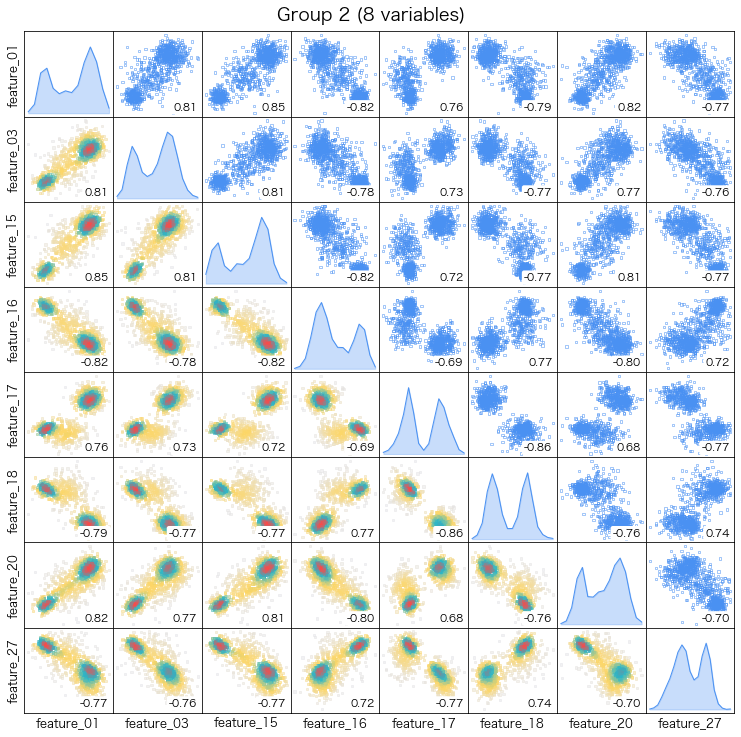

In [33]:
cmap = create_cmap(["#fe4a49" , "#2ab7ca" , "#fed766" , "#e6e6ea"])
axes = cluster_matrix(X0, off_diagonal="both", scatter_kwds={"cmap":cmap}, colors=["#4a91f2"])
plt.gcf().suptitle('Group {} ({:,d} variables)'.format(cluster, X0.shape[1]), fontsize=18)
plt.tight_layout()

Let's select variable, with the lowest **RS_Ratio** from each **Cluster**.

In [34]:
X = X[vc.r2.reset_index().groupby('Cluster').first()["Variable"].values].copy()

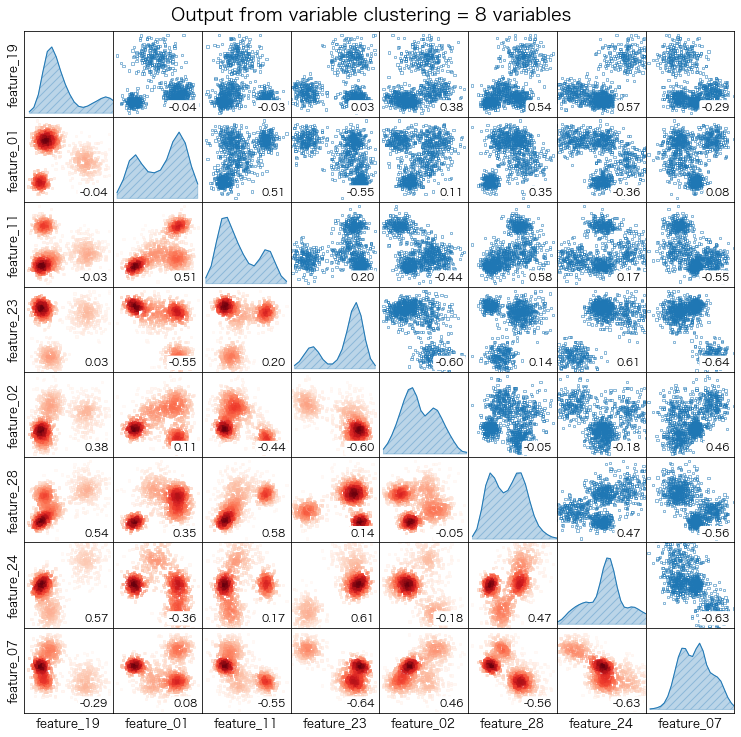

In [35]:
axes = cluster_matrix(X, off_diagonal="both", scatter_kwds=dict(cmap="Reds"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True)
plt.gcf().suptitle('Output from variable clustering = {:,d} variables'
                   .format(X.shape[1]), fontsize=18)
plt.tight_layout()

### <font color="green" size=5> Standardization </font>

Standardize X by using [**`StandardScaler`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [36]:
Scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_std  = pd.DataFrame(Scaler.transform(X), columns=X.columns)

### <font color="green" size=5> Data Suitability </font>

**Bartlett's Sphericity** tests the hypothesis, $H_{0}$ that the correlation matrix ($n$ by $n$) is equal to the identity matrix $\bf{I_{n}}$, which would indicate that your variables are unrelated and therefore unsuitable for structure detection.

In [37]:
Cal_Bartlett(X_std)

BartlettTest(chisq=11431.155883781588, df=28.0, pvalue=0.0)

**The Kaiser-Meyer-Olkin Measure of Sampling Adequacy** is a statistic that indicates the proportion of variance in variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with your data. If the value is less than 0.50, the results of the factor analysis probably won't be very useful. Reference: [ [1](https://www.ibm.com/docs/en/spss-statistics/23.0.0?topic=detection-kmo-bartletts-test) ]

$KMO = \frac{\sum\sum_{i \ne j}r^{2}_{ij}}{\sum\sum_{i \ne j}r^{2}_{ij} + \sum\sum_{i \ne j}a^{2}_{ij}}$ 

where $r_{ij}$ is a correlation between $x_{i}$, and $x_{j}$ and $a_{ij}$ is a partial correlation between $x_{i}$ and $x_{j}$; $i \ne j$

In [38]:
MSATest, KMOTest = Cal_KMOScore(X_std)

In [39]:
KMOTest

KMOTest(Score=0.71517059682901, Corr=9.83143859603399, PartialCorr=3.9155451860531643)

**Measure of Sampling Adequacy** is a statistic that indicates the proportion of variance in $x_{i}$ $(i = 1,2,\ldots ,k)$ that might be caused by underlying factors. 

$MSA_{i} = \frac{\sum_{i \ne j}r^{2}_{ij}}{\sum_{i \ne j}r^{2}_{ij} + \sum_{i \ne j}a^{2}_{ij}}$ 

In [40]:
MSATest.Score

array([0.58032538, 0.55697787, 0.66959434, 0.70007628, 0.73258349,
       0.77158099, 0.7940603 , 0.85185422])

**Squared Multiple Correlation coefficient** (SMC), $R^{2}$, measures the proportion of total variance on the variables, $x_{i}$, that is accounted for by a set of $k-1$ predictors, 
$X$ = {$x_{1}, x_{2},\ldots,x_{k}$}, and $x_{i}\notin X$. It provides an estimate for the overall predictive power of a set of predictors. Low $R^{2}_{i}$ should not be included in factor analysis as it represents a low correlation between $x_{i}$ and other $X$ e.g. $R^{2}< 0.5$.

In [41]:
Cal_SMC(X_std).T

,feature_19,feature_01,feature_11,feature_23,feature_02,feature_28,feature_24,feature_07
SMC,0.68,0.73,0.72,0.78,0.62,0.68,0.71,0.71


### <font color="green" size=5> Factor Extraction (Dimension Reduction) </font>

`PrincipalComponents` performs dimension reduction algorithm so-called Principal Component Analysis (PCA) on the correlation of X.

In [42]:
PCF = PrincipalComponents(minprop=0.8, mineigval=1.0).fit(X_std)

In order to decide which factor(s) can be dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues ($\lambda$). The factors or eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data. Those are the ones to be dropped. In order to do so, the common approach is to rank the eigenvalues ($\lambda$) from highest to lowest and choose the top `k` eigenvectors, whose value is above the minimum threshold e.g. 1.

Alternatively, summation of eigenvalues represents a proportion of variance that can be used as an indicator to decide an appropriate number of eigenvectors. First we rank eigenvectors by their corresponding eigenvalues ($\lambda$) from highest to lowest, and choose `k` eigenvectors, whose cumulative proportion of variance is above or equal to threshold e.g. 0.80 (80%).

Attribute: `variances`

In [43]:
PCF.variances

,Eigenvalues,% Variance,Cumulative %
Factor,,,
PC1,3.26,0.41,0.41
PC2,1.99,0.25,0.66
PC3,1.75,0.22,0.87
PC4,0.26,0.03,0.91
PC5,0.23,0.03,0.94
PC6,0.22,0.03,0.96
PC7,0.16,0.02,0.98
PC8,0.14,0.02,1.00


We can quantify how much of the variance of a given PC is explained by a given original variable by finding the correlation coefficient between variables and PCs. This could be done conventionally. However, if PCA is done on the correlations, the following approach is also applicable. $PC_{k}$ is associated with an eigenvector $\hat{X}_{k}$ and the corresponding eigenvalue $\lambda_{k}$. A loadings vector $\hat{L}_{k}$ is given by $\hat{L}_{i} = \hat{X}_{k}\sqrt{\lambda_{k}}$. Its elements are correlations of this PC with the respective original variables.

The communality (`communalities`)  is the sum of the squared component loadings (correlation) up to the number of components that gets extracted.

In [44]:
PCF.communalities

Extraction                      
                  PC1  PC2  PC3 Communality
feature_19       0.16 0.07 0.66        0.90
feature_01       0.02 0.80 0.09        0.91
feature_11       0.34 0.29 0.26        0.89
feature_23       0.56 0.33 0.02        0.90
feature_02       0.26 0.09 0.50        0.85
feature_28       0.45 0.37 0.03        0.86
feature_24       0.64 0.03 0.18        0.85
feature_07       0.82 0.00 0.01        0.83
Total            3.26 1.99 1.75        6.99

Apply the dimensionality reduction on X.

In [45]:
PC = PCF.transform(X_std, 3)
PC.head(5)

,PC1,PC2,PC3
0,-1.59,0.98,-1.66
1,-1.03,0.91,-1.98
2,-1.41,-0.71,1.41
3,-1.48,0.96,-1.56
4,-1.40,0.73,-1.42


Visaulize principal components in pair and see how features influence the spread or cluster of data.

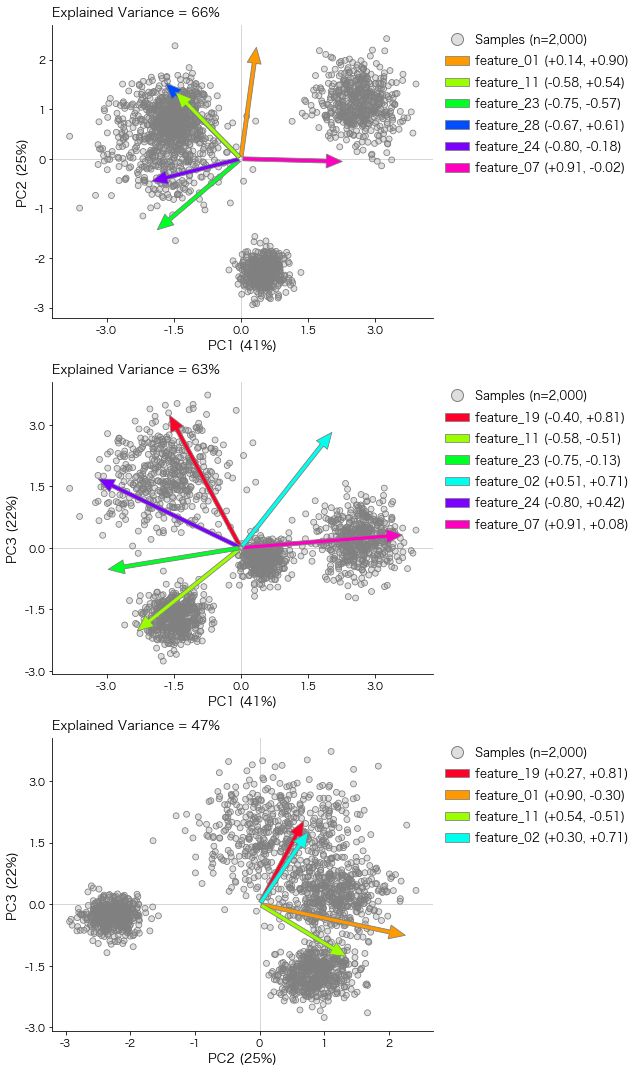

In [46]:
arrow_colors=matplotlib_cmap(name="gist_rainbow", n=X.shape[1])
fig, axes = plt.subplots(3, 1, figsize=(9,15))
kwds = dict(arrow_colors=arrow_colors, 
            max_display=8, show_corr=True, whis=3)

for n,pc_pair in enumerate(combinations(range(PC.shape[1]),2)):
    kwds.update(dict(pc_pair=pc_pair, ax=axes[n]))
    ax = PCF.plot(**kwds)
plt.tight_layout()

Visualize all selected principal components.

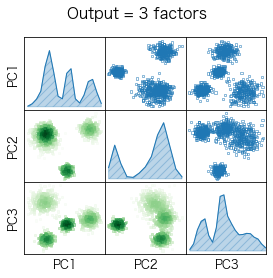

In [47]:
axes = cluster_matrix(PC.copy(), off_diagonal="both", scatter_kwds=dict(cmap="Greens"),
                      hist_kwds=dict(fill_kwds=dict(hatch="///")), 
                      show_corr=False)
plt.gcf().suptitle('Output = {:,d} factors'.format(PC.shape[1]), fontsize=15)
plt.tight_layout()

### <font color="green" size=5> Factor Rotation </font>

PCA often needs rotation for easier interpretation. Factor rotation tries to maximize variance of the squared loadings in each factor so that each factor has only a few variables with large loadings and many other variables with low loadings. References: [ [1](https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html#factor-analyzer-analyze-module) ], and [ [2](https://stats.idre.ucla.edu/spss/seminars/efa-spss/) ]. 

Rotation Methods
- orthogonal : {"varimax", "equamax", "quartimax"}
- oblique : {"promax", "oblimax", "oblimin", "quartimin"}

In [48]:
from factor_analyzer import FactorAnalyzer
fa_estimator = FactorAnalyzer(n_factors=3, method="principal", rotation="varimax").fit(X_std)

`FactorRotation` provides statistical information towards interpretation of factor loadings, specific variances, and communalities

In [49]:
rotate = FactorRotation().fit(fa_estimator, X_std.columns)

Variance explained by corresponding rotated factors. Just like in PCA the more factors get extracted, the less variance explained by each successive factor. Moreover, we notice that the total variance from rotation given the same number of factors, remains unchanged. This is due to **method** i.e. **minres**, **ml**, or **principal**, which dictates the initial variance (common, and unique) for algorithm to begin with.

In [52]:
rotate.variances

Initial                         Extraction                        
     Total % Variance Cumulative %      Total % Variance Cumulative %
F1    3.26       0.41         0.41       2.71       0.34         0.34
F2    1.99       0.25         0.66       2.23       0.28         0.62
F3    1.75       0.22         0.87       2.05       0.26         0.87
F4    0.26       0.03         0.91        NaN        NaN          NaN
F5    0.23       0.03         0.94        NaN        NaN          NaN
F6    0.22       0.03         0.96        NaN        NaN          NaN
F7    0.16       0.02         0.98        NaN        NaN          NaN
F8    0.14       0.02         1.00        NaN        NaN          NaN

The elements are squared loadings, which represent the variance of each item that can be explainded by the corresponding factor. 

In [53]:
rotate.communalities

Extraction                                 
                   F1   F2   F3 Communality Uniqueness
feature_19       0.02 0.87 0.00        0.90       0.10
feature_01       0.17 0.01 0.73        0.91       0.09
feature_11       0.16 0.00 0.72        0.89       0.11
feature_23       0.82 0.03 0.04        0.90       0.10
feature_02       0.69 0.12 0.04        0.85       0.15
feature_28       0.02 0.44 0.39        0.86       0.14
feature_24       0.29 0.55 0.01        0.85       0.15
feature_07       0.53 0.20 0.10        0.83       0.17
Total            2.71 2.23 2.05        6.99       1.01

Correlation of each item with the corresponding factor.

Use `create_cmap(colors=None)` to create matplotlib.colors.Colormap (Colormaps).

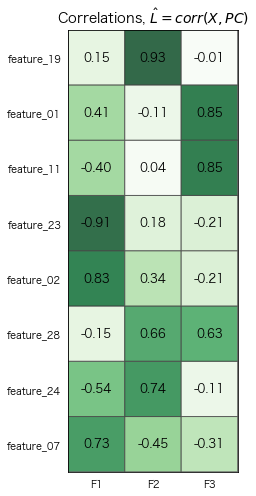

In [54]:
ax = plt.subplots(figsize=(3.5,7))[1]
ax = rotate.plotting(value="loading", ax=ax, cmap="Greens")

Residual variances that cannot be explained by factors. These values should be close zero in absolute term.

RMSR = 0.038


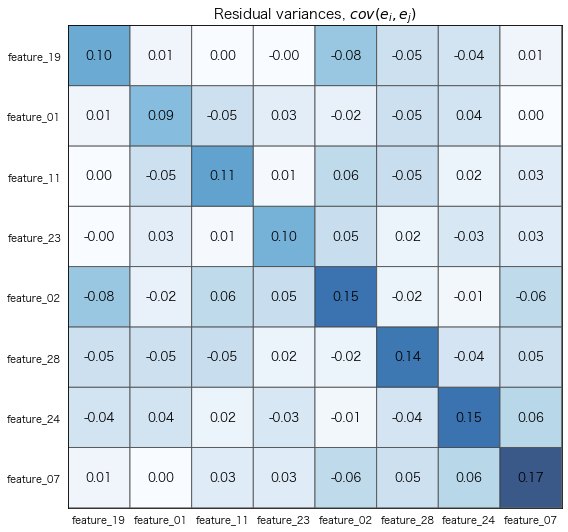

In [55]:
print("RMSR = {:,.3f}".format(rotate.rmsr))
ax = rotate.plotting(value="unique")

Apply the dimensionality reduction on X.

In [56]:
n_factors = fa_estimator.n_factors
RotatedFactors = pd.DataFrame(fa_estimator.transform(X_std))
RotatedFactors.columns = [f"F{n+1}" for n in range(n_factors)]
RotatedFactors.head(5)

,F1,F2,F3
0,-0.87,-0.34,1.40
1,-0.75,-0.73,1.38
2,-0.41,1.18,-0.68
3,-0.79,-0.33,1.34
4,-0.80,-0.30,1.14


Visualize all selected principal components.

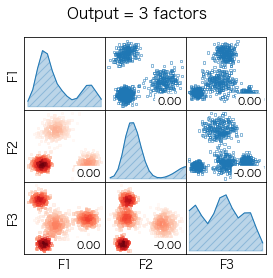

In [57]:
axes = cluster_matrix(RotatedFactors.copy(), off_diagonal="both",
                      scatter_kwds=dict(cmap="Reds"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True)
plt.gcf().suptitle('Output = {:,d} factors'
                   .format(RotatedFactors.shape[1]), fontsize=15)
plt.tight_layout()

### <font color="green" size=5> Clustering </font>

Using K-means algorithm from [**`sklearn.cluster.KMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [58]:
from sklearn.cluster import KMeans
labels = np.hstack([KMeans(n_clusters=n, random_state=99)
                    .fit_predict(RotatedFactors).reshape(-1,1) 
                    for n in range(1, 11)])

In [59]:
labels

array([[0, 1, 2, ..., 3, 1, 2],
       [0, 1, 2, ..., 3, 7, 4],
       [0, 1, 2, ..., 0, 5, 6],
       ...,
       [0, 0, 1, ..., 2, 3, 0],
       [0, 1, 2, ..., 3, 7, 4],
       [0, 1, 0, ..., 1, 2, 1]], dtype=int32)

### <font color="green" size=5> Clustering Validation </font>

We use **`eval_cluster`** from [**`cluster_validity.py`**](https://github.com/Nak007/cluster-validity).

In [60]:
evaluate = eval_cluster(n_bootstraps=10, random_state=99).fit(RotatedFactors.values, labels)

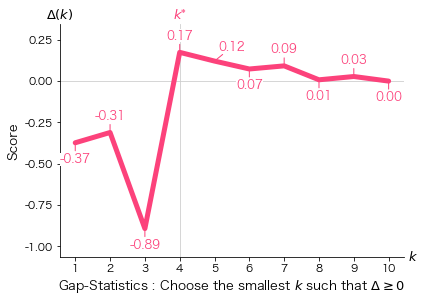

In [61]:
ax = evaluate.plot("g2")

### <font color="green" size=5> Clustering Analysis </font>

Select parameters and method that best answer business interpretation and practicality.

In [78]:
colors = ["#ef476f", "#ffd166", "#06d6a0", "#118ab2", "#073b4c"]

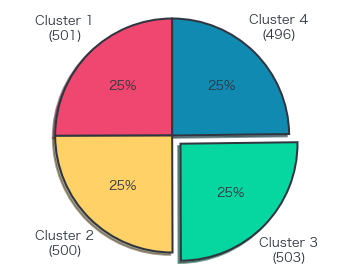

In [79]:
ax = cluster_pie(labels[:,3], colors=colors)

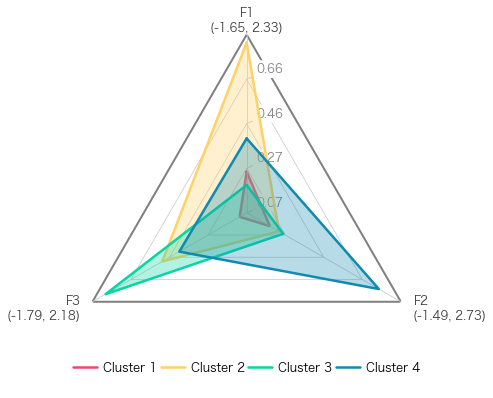

In [80]:
ax = cluster_radar(RotatedFactors, labels[:,3], colors=colors)

Use pairwise comparison to observe interaction of variables

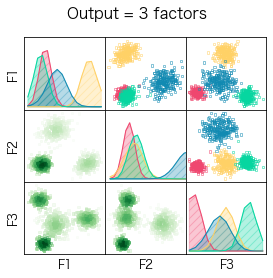

In [81]:
axes = cluster_matrix(RotatedFactors.copy(), labels[:,3],off_diagonal="both",
                      scatter_kwds=dict(cmap="Greens"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=False, colors=colors)
plt.gcf().suptitle('Output = {:,d} factors'
                   .format(RotatedFactors.shape[1]), fontsize=15)
plt.tight_layout()

Alternatively, we can use features or other numerical variables to observe the characteristics of each cluster.

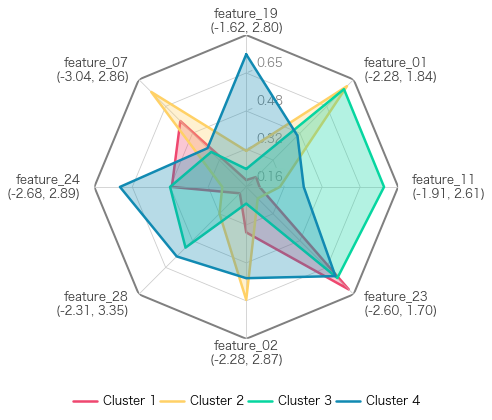

In [82]:
ax = cluster_radar(X_std, labels[:,3], colors=colors)

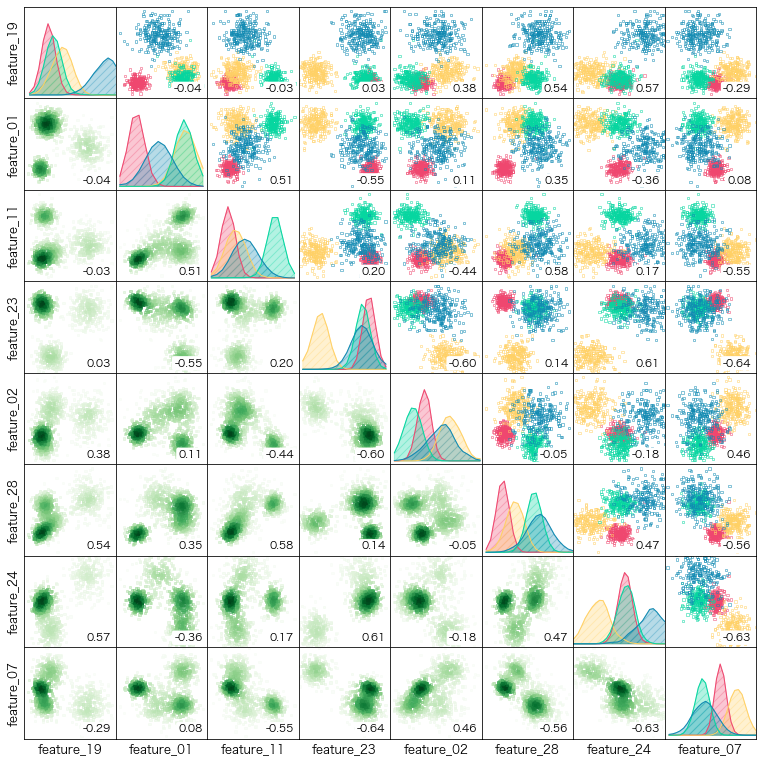

In [83]:
axes = cluster_matrix(X_std.copy(), labels[:,3], off_diagonal="both",
                      scatter_kwds=dict(cmap="Greens"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True, colors=colors)

### <font color="green" size=5> Final Cluster </font>

In [76]:
final_X = pd.concat((X_std, PC, RotatedFactors), axis=1)
final_X["cluster"] = labels[:,3]

In [77]:
final_X.head(5)

,feature_19,feature_01,feature_11,feature_23,feature_02,feature_28,feature_24,feature_07,PC1,PC2,PC3,F1,F2,F3,cluster
0,0.04,1.07,1.78,0.89,-1.23,0.50,-0.13,-0.49,-1.59,0.98,-1.66,-0.87,-0.34,1.40,2
1,-0.36,0.99,1.65,0.47,-1.23,0.21,-0.58,-0.56,-1.03,0.91,-1.98,-0.75,-0.73,1.38,2
2,1.69,-0.51,-0.86,0.80,-0.71,0.53,1.03,-0.17,-1.41,-0.71,1.41,-0.41,1.18,-0.68,3
3,-0.52,0.98,1.60,0.45,-0.72,0.39,0.13,-1.11,-1.48,0.96,-1.56,-0.79,-0.33,1.34,2
4,-0.57,0.82,1.04,0.73,-1.05,1.04,0.12,-0.42,-1.40,0.73,-1.42,-0.80,-0.30,1.14,2
